In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive


class MnistDataSet(torch.utils.data.Dataset):
    def __init__(self):
        dataset1 = datasets.MNIST(root='./mnist_data/',
                               train=True,
                               download=True)

        dataset2 = datasets.MNIST(root='./mnist_data/',
                                    train=False,
                                    download=True)

        self.data = torch.cat([dataset1.data, dataset2.data], dim=0).reshape(-1, 1, 28, 28).float() / 255.0
        # self.data = dataset1.data.reshape(-1, 1, 28, 28).float() / 255.0

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]


dataset = MnistDataSet()
print('data.shape :', dataset.data.shape)
print('data.dtype :', dataset.data.dtype)
print('max :', dataset.data.max().item())
print('min :', dataset.data.min().item())

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


data.shape : torch.Size([70000, 1, 28, 28])
data.dtype : torch.float32
max : 1.0
min : 0.0





In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)

Fri Oct  9 13:07:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    29W / 149W |     11MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    

class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)

In [4]:
class GUMBEL_VAE(torch.nn.Module):

    def __init__(self, N, K):
        super(GUMBEL_VAE, self).__init__()
        self.N = N 
        self.K = K

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            Flatten(),
            torch.nn.Linear(6272, 1024),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, N * K)
        ).to(device)


        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(N * K, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 7*7*128),
            torch.nn.ReLU(),
            Reshape((128,7,7,)),
            torch.nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 1, 4, 2, padding=1),
            torch.nn.Sigmoid()
        ).to(device)

    def encode(self, X):
        return self.encoder(X)

    def decode(self, Z):
        return self.decoder(Z)

    def forward(self, X_q, tau, ST):
        unpacked_logits = self.encode(X_q)
        logits = unpacked_logits.reshape(X_q.size(0), self.N, self.K)
        Z_q = F.gumbel_softmax(logits, tau, ST, dim=-1)
        X_p = self.decode(Z_q.reshape(X_q.size(0), -1))
        return logits, Z_q, X_p


In [12]:
mb_size = 64
loader = torch.utils.data.DataLoader(dataset=dataset,
                                     batch_size=mb_size,
                                     shuffle=True,
                                     drop_last=True)
X_DIM = 1 * 28 * 28
N = 8
K = 10
prior = torch.FloatTensor([1/K] * K).to(device)
model = GUMBEL_VAE(N=N, K=K)
solver = optim.Adam(model.parameters(), lr=1e-4)

In [13]:
def KLD(logits):
    qzx = F.softmax(logits, dim=-1)
    kld = qzx * (torch.log(qzx + 1e-20) - torch.log(prior + 1e-20))
    return kld.sum(dim=[1, 2])

num_epochs = 100
RATE = []
DISTORTION = []
for epoch in range(num_epochs):
    RATE_AVG = 0.0
    DISTORTION_AVG = 0.0
    for _, X_q in enumerate(loader):
        solver.zero_grad()
        X_q = X_q.to(device)
        logits, Z_q, X_p = model(X_q, tau=0.01, ST=True)
        rate = KLD(logits).mean()
        distortion = F.binary_cross_entropy(X_p, X_q, reduction='mean') * X_DIM
        loss = rate + distortion
        loss.backward()
        solver.step()
        RATE_AVG += rate.item()
        DISTORTION_AVG += distortion.item()
    RATE_AVG /= len(loader)    
    DISTORTION_AVG /= len(loader)
    RATE.append(RATE_AVG)
    DISTORTION.append(DISTORTION_AVG)

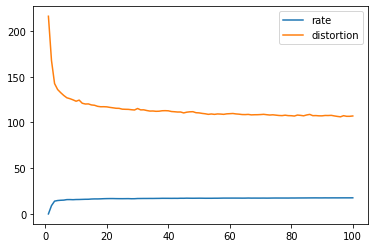

In [14]:
plt.plot(np.arange(1, len(RATE)+1), RATE, label='rate')
plt.plot(np.arange(1, len(DISTORTION)+1), DISTORTION, label='distortion')
plt.legend()
plt.show()

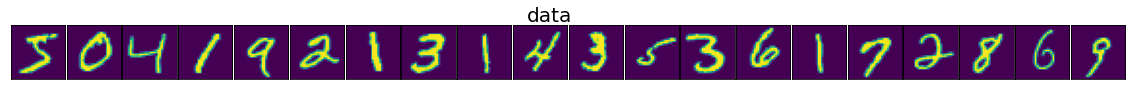

[6 3 4 8 9 4 5 6]
[6 1 9 0 8 3 8 3]
[9 9 9 4 7 5 0 5]
[7 9 7 1 2 4 7 0]
[1 1 8 0 3 2 2 1]
[0 1 9 7 1 9 1 7]
[7 6 6 6 5 4 3 1]
[6 3 6 8 9 9 4 0]
[7 7 6 8 5 8 3 1]
[1 7 9 5 2 6 1 4]
[6 5 2 2 1 4 5 6]
[1 8 9 4 2 4 7 3]
[6 3 2 6 0 8 0 3]
[5 4 5 7 1 2 1 7]
[7 7 6 8 8 8 3 1]
[4 7 9 0 2 1 0 4]
[3 8 2 5 9 0 5 1]
[1 5 9 5 2 9 8 0]
[5 0 9 3 7 4 3 7]
[4 7 9 8 2 0 6 7]


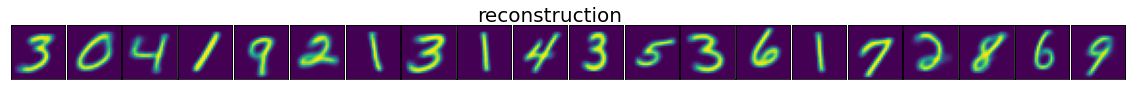

In [34]:

num_image = 20

fig = plt.figure(figsize=(20, 2))

n = 0
for i in range(num_image):
    _fig = fig.add_subplot(2, num_image, n + 1, xticks=[], yticks=[])
    _fig.imshow(dataset.data[n].cpu().reshape(28, 28).numpy())
    n += 1
fig.suptitle('data', y=1.01, fontsize=20)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

fig = plt.figure(figsize=(20, 2))

n = 0
with torch.no_grad():
    for i in range(num_image):
        logits, Z_q, X_p = model(dataset.data[n].reshape(1, 1, 28, 28).to(device), tau=0.01, ST=True)
        _fig = fig.add_subplot(2, num_image, n + 1, xticks=[], yticks=[])
        _fig.imshow(X_p.cpu().data.numpy().reshape(28, 28))
        code = torch.argmax(Z_q.squeeze(), dim=-1).cpu().numpy()
        print(code)
        n += 1
fig.suptitle('reconstruction', y=1.01, fontsize=20)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

discrete code: 
 [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


discrete code: 
 [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


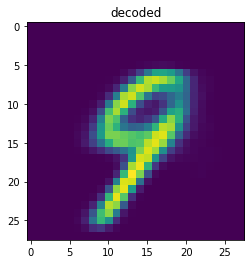

In [53]:
discrete_code = [4, 7, 9, 8, 2, 0, 6, 7]
one_hot_code = np.zeros((8, 10), dtype=np.float)
for i in range(8):
    one_hot_code[i][discrete_code[i]] = 1.0
print('discrete code: \n', one_hot_code)
one_hot_code = torch.from_numpy(one_hot_code.reshape(1, -1)).float().to(device)

decoded = model.decode(one_hot_code).cpu().data.numpy().reshape(28, 28)
plt.title('decoded')
plt.imshow(decoded)
plt.show()

discrete code: 
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


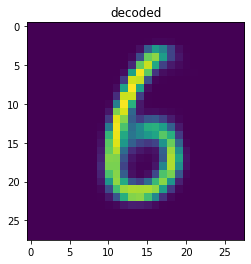

In [54]:
discrete_code = [5, 0, 9, 3, 7, 4, 3, 7]
one_hot_code = np.zeros((8, 10), dtype=np.float)
for i in range(8):
    one_hot_code[i][discrete_code[i]] = 1.0
print('discrete code: \n', one_hot_code)
one_hot_code = torch.from_numpy(one_hot_code.reshape(1, -1)).float().to(device)

decoded = model.decode(one_hot_code).cpu().data.numpy().reshape(28, 28)
plt.title('decoded')
plt.imshow(decoded)
plt.show()